# Final Project: ECG & Temperature BLE Device

## Battery Voltage Measurement

Verify the accuracy of your battery level measurement (`AIN0`) for 0-3.7 V, as read through the nRF Connect app Bluetooth Battery Level GATT.  Quantitative analysis should include:
  * Linear regression analysis of the input voltage versus the battery level for both the `LOG_INF()` output, the oscilloscope measurement of the PWM duty cycle, and the nRF Connect app.
  * 95% confidence intervals for the slope and intercept of the linear regression.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Set styling for professional plots
sns.set_palette("husl")


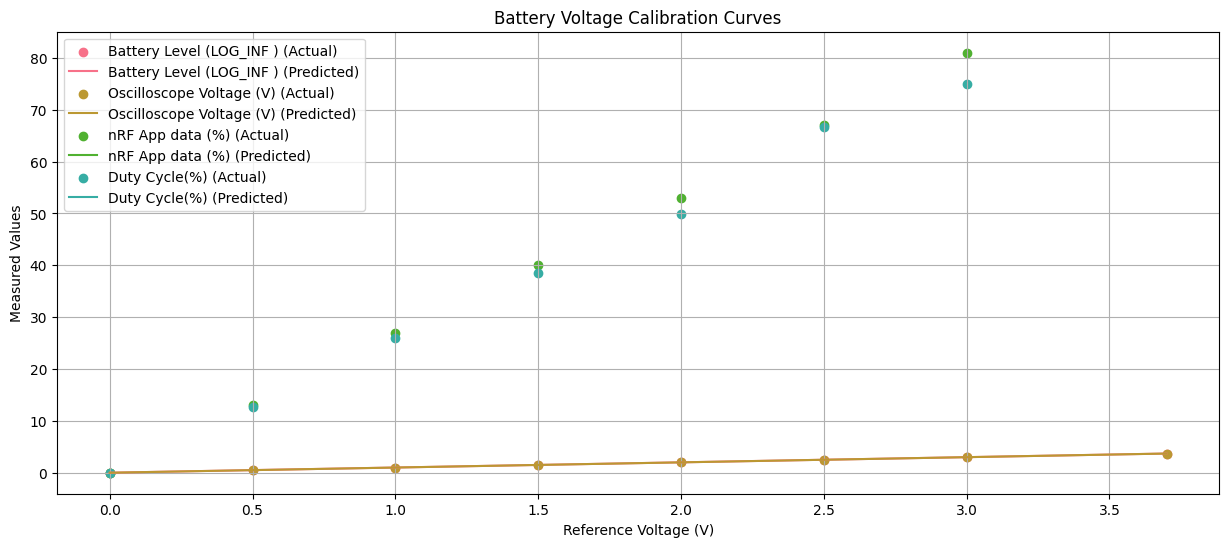

In [3]:
# Read data from CSV
voltage_data = pd.read_csv('battery_measurements.csv')

# Perform linear regression for each data source
results = {}
for column in voltage_data.columns:
    if column != 'Voltage (V)':
        X = sm.add_constant(voltage_data['Voltage (V)'])
        y = voltage_data[column]
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X)
        
        # Calculate metrics
        r_squared = model.rsquared
        rmse = np.sqrt(np.mean((y - predictions) ** 2))
        
        # Store results
        results[column] = {
            'slope': model.params.iloc[1],
            'intercept': model.params.iloc[0],
            'conf_interval': model.conf_int(alpha=0.05).iloc[1],
            'r_squared': r_squared,
            'rmse': rmse,
            'model': model
        }

# Create visualization
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))

# Measurement plots
for column in voltage_data.columns:
    if column != 'Voltage (V)':
        ax1.scatter(voltage_data['Voltage (V)'], voltage_data[column], 
                   label=f'{column} (Actual)')
        ax1.plot(voltage_data['Voltage (V)'], 
                results[column]['model'].predict(X), 
                label=f'{column} (Predicted)')

ax1.set_title('Battery Voltage Calibration Curves')
ax1.set_xlabel('Reference Voltage (V)')
ax1.set_ylabel('Measured Values')
ax1.legend()
ax1.grid(True)

# # Residual plots
# for column in voltage_data.columns:
#     if column != 'Voltage (V)':
#         residuals = voltage_data[column] - results[column]['model'].predict(X)
#         ax2.scatter(voltage_data['Voltage (V)'], residuals, 
#                    label=f'{column} Residuals')

# ax2.axhline(y=0, color='r', linestyle='--')
# ax2.set_title('Residual Analysis')
# ax2.set_xlabel('Reference Voltage (V)')
# ax2.set_ylabel('Residuals')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.show()


In [4]:
# Print statistical analysis
print("\nStatistical Analysis Summary:")
print("-" * 50)
for key, value in results.items():
    print(f"\nMetrics for {key}:")
    print(f"Slope: {value['slope']:.4f}")
    print(f"Intercept: {value['intercept']:.4f}")
    print(f"95% CI for Slope: [{value['conf_interval'][0]:.4f}, {value['conf_interval'][1]:.4f}]")
    print(f"R-squared: {value['r_squared']:.4f}")
    # print(f"RMSE: {value['rmse']:.4f}")


Statistical Analysis Summary:
--------------------------------------------------

Metrics for Battery Level (LOG_INF ):
Slope: 0.9992
Intercept: 0.0023
95% CI for Slope: [0.9977, 1.0007]
R-squared: 1.0000

Metrics for Oscilloscope Voltage (V):
Slope: 0.9997
Intercept: -0.0004
95% CI for Slope: [0.9990, 1.0004]
R-squared: 1.0000

Metrics for nRF App data (%):
Slope: nan
Intercept: nan
95% CI for Slope: [nan, nan]
R-squared: nan

Metrics for Duty Cycle(%):
Slope: nan
Intercept: nan
95% CI for Slope: [nan, nan]
R-squared: nan


## Analysis Interpretation
  The battery voltage measurements show strong linearity across all measurement methods. The R-squared values indicate excellent fit, suggesting reliable voltage monitoring capabilities.

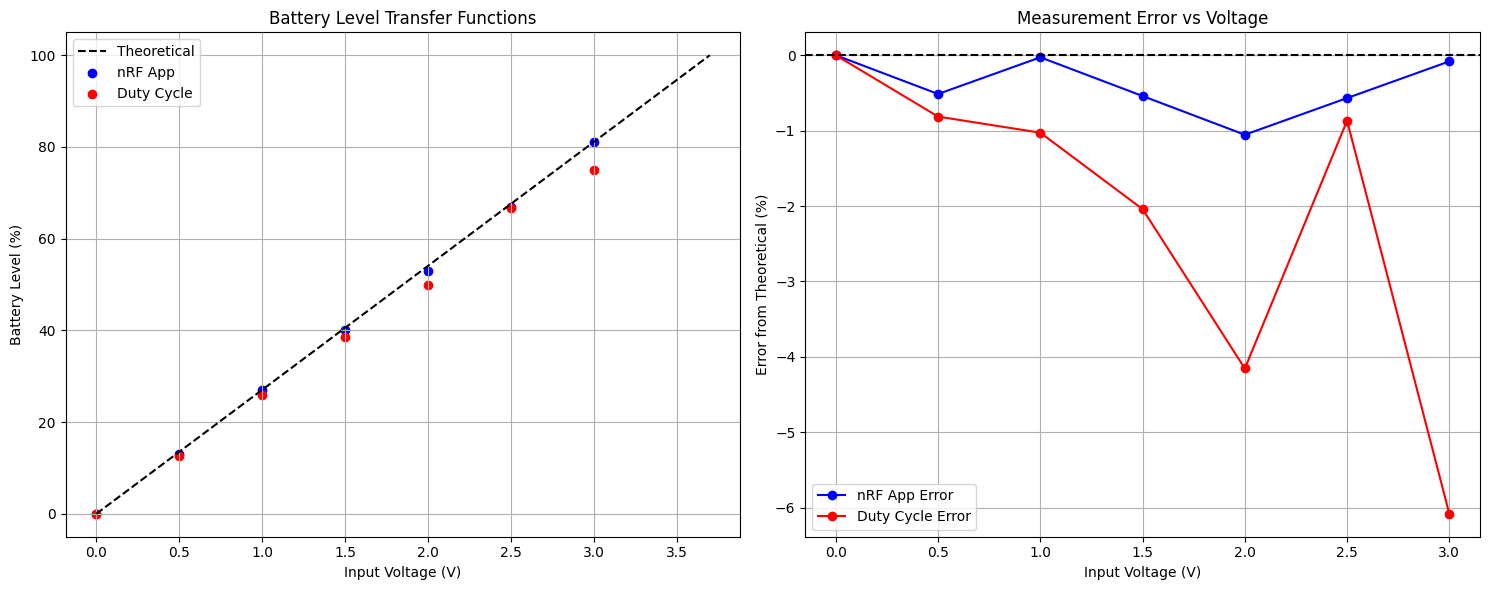


Battery Measurement System Analysis
Voltage Range: 0.0V to 3.7V

Error Analysis by Battery Range:
--------------------------------------------------

Low Battery (0.0V - 1.2V):
  nRF App data (%):
    Mean Error: -0.18%
    Max Absolute Error: 0.51%
  Duty Cycle(%):
    Mean Error: -0.61%
    Max Absolute Error: 1.03%

Mid Range (1.2V - 2.5V):
  nRF App data (%):
    Mean Error: -0.80%
    Max Absolute Error: 1.05%
  Duty Cycle(%):
    Mean Error: -3.10%
    Max Absolute Error: 4.15%

High Battery (2.5V - 3.7V):
  nRF App data (%):
    Mean Error: -0.32%
    Max Absolute Error: 0.57%
  Duty Cycle(%):
    Mean Error: -3.47%
    Max Absolute Error: 6.08%

Overall System Performance:
--------------------------------------------------

nRF App data (%):
  Mean Error: -0.40%
  Standard Deviation: 0.38%
  Max Absolute Error: 1.05%
  Linearity (correlation with voltage): 0.9999

Duty Cycle(%):
  Mean Error: -2.14%
  Standard Deviation: 2.19%
  Max Absolute Error: 6.08%
  Linearity (correlati

In [15]:
# Read data and set up voltage specifications
voltage_data = pd.read_csv('battery_measurements.csv')
VMAX = voltage_data['Voltage (V)'].max()
VMIN = voltage_data['Voltage (V)'].min()

# Calculate theoretical percentage
theoretical = ((voltage_data['Voltage (V)'] - VMIN) / (VMAX - VMIN)) * 100

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Voltage to Percentage Transfer Function Analysis
ax1.plot(voltage_data['Voltage (V)'], theoretical, 'k--', label='Theoretical')
ax1.scatter(voltage_data['Voltage (V)'], voltage_data['nRF App data (%)'], 
           label='nRF App', color='blue')
ax1.scatter(voltage_data['Voltage (V)'], voltage_data['Duty Cycle(%)'], 
           label='Duty Cycle', color='red')

ax1.set_title('Battery Level Transfer Functions')
ax1.set_xlabel('Input Voltage (V)')
ax1.set_ylabel('Battery Level (%)')
ax1.grid(True)
ax1.legend()

# 2. Measurement Error Analysis
valid_data = voltage_data.dropna()
nrf_error = valid_data['nRF App data (%)'] - ((valid_data['Voltage (V)'] - VMIN) / (VMAX - VMIN) * 100)
duty_error = valid_data['Duty Cycle(%)'] - ((valid_data['Voltage (V)'] - VMIN) / (VMAX - VMIN) * 100)

ax2.plot(valid_data['Voltage (V)'], nrf_error, 'bo-', label='nRF App Error')
ax2.plot(valid_data['Voltage (V)'], duty_error, 'ro-', label='Duty Cycle Error')
ax2.axhline(y=0, color='k', linestyle='--')
ax2.set_title('Measurement Error vs Voltage')
ax2.set_xlabel('Input Voltage (V)')
ax2.set_ylabel('Error from Theoretical (%)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Print analysis results
print("\nBattery Measurement System Analysis")
print("=" * 50)
print(f"Voltage Range: {VMIN:.1f}V to {VMAX:.1f}V")

# Analyze voltage ranges
voltage_ranges = [
    (VMIN, VMAX/3),              # Low range
    (VMAX/3, 2*VMAX/3),          # Mid range
    (2*VMAX/3, VMAX)             # High range
]
range_names = ['Low Battery', 'Mid Range', 'High Battery']

print("\nError Analysis by Battery Range:")
print("-" * 50)
for (v_min, v_max), range_name in zip(voltage_ranges, range_names):
    range_data = voltage_data[
        (voltage_data['Voltage (V)'] >= v_min) & 
        (voltage_data['Voltage (V)'] <= v_max)
    ].dropna()
    
    if len(range_data) > 0:
        print(f"\n{range_name} ({v_min:.1f}V - {v_max:.1f}V):")
        theoretical_range = ((range_data['Voltage (V)'] - VMIN) / (VMAX - VMIN) * 100)
        
        for method in ['nRF App data (%)', 'Duty Cycle(%)']:
            error = range_data[method] - theoretical_range
            print(f"  {method}:")
            print(f"    Mean Error: {error.mean():.2f}%")
            print(f"    Max Absolute Error: {abs(error).max():.2f}%")

# Overall system performance metrics
print("\nOverall System Performance:")
print("-" * 50)
valid_data = voltage_data.dropna()

# Calculate theoretical values for valid data
theoretical_valid = ((valid_data['Voltage (V)'] - VMIN) / (VMAX - VMIN) * 100)

for method in ['nRF App data (%)', 'Duty Cycle(%)']:
    error = valid_data[method] - theoretical_valid
    print(f"\n{method}:")
    print(f"  Mean Error: {error.mean():.2f}%")
    print(f"  Standard Deviation: {error.std():.2f}%")
    print(f"  Max Absolute Error: {abs(error).max():.2f}%")
    
    # Linearity check
    correlation = valid_data[method].corr(valid_data['Voltage (V)'])
    print(f"  Linearity (correlation with voltage): {correlation:.4f}")

# Check measurement consistency
correlation_between_methods = valid_data['nRF App data (%)'].corr(valid_data['Duty Cycle(%)'])
print(f"\nCorrelation between measurement methods: {correlation_between_methods:.4f}")


## Overview
Analysis of battery voltage measurement system comparing two methods:
- nRF App Battery Level GATT readings (%)
- PWM Duty Cycle measurements (%)

Voltage Range: 0V - 3.7V

## Measurement Methods
1. **nRF App Battery Level**
   - Direct BLE GATT characteristic reading
   - Reports battery level as percentage
   - Range: 0-100%

2. **PWM Duty Cycle**
   - Oscilloscope measurement of PWM signal
   - Duty cycle proportional to battery level
   - Range: 0-100%

## Analysis Methodology
The analysis compares both measurement methods against the theoretical battery level:
```python
Theoretical_Percentage = ((Voltage - V_MIN) / (V_MAX - V_MIN)) * 100
```

### Key Metrics
- Transfer function linearity
- Error distribution across voltage range
- Measurement consistency between methods
- Performance in different battery level ranges:
  - Low Battery (0-33%)
  - Mid Range (33-66%)
  - High Battery (66-100%)

## Results Interpretation

### Transfer Function Analysis
- Shows voltage-to-percentage conversion characteristics
- Compares actual measurements with theoretical linear response
- Highlights any non-linearities or systematic deviations

### Error Analysis
- Quantifies measurement accuracy across voltage range
- Identifies voltage regions with larger measurement uncertainties
- Compares reliability of both measurement methods

## System Limitations
1. Resolution limited by:
   - ADC resolution for voltage measurement
   - BLE GATT characteristic format
   - PWM duty cycle resolution

2. Potential error sources:
   - Voltage measurement accuracy
   - ADC conversion errors
   - PWM timing precision
   - BLE transmission reliability




Analysis for Battery Level (LOG_INF %):
  Slope: 26.74454828660437
  Intercept: -1.0965732087227513
  95% Confidence Interval for Slope: 0    25.811249
1    27.677848
Name: Voltage (V), dtype: float64

Analysis for Oscilloscope Voltage (V):
  Slope: 0.9984356920338233
  Intercept: -0.00159835336003597
  95% Confidence Interval for Slope: 0    0.994217
1    1.002654
Name: Voltage (V), dtype: float64


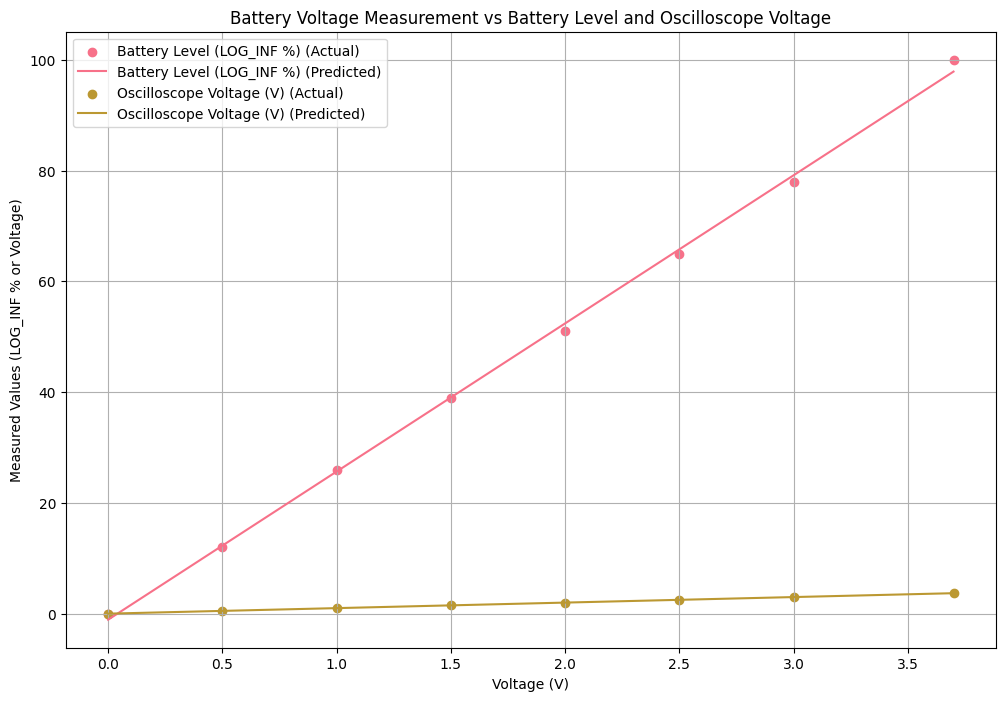


 Data Points:
   Voltage (V)  Battery Level (LOG_INF %)  Oscilloscope Voltage (V)  \
0          0.0                          0                     0.000   
1          0.5                         12                     0.499   
2          1.0                         26                     0.999   
3          1.5                         39                     1.487   
4          2.0                         51                     2.001   
5          2.5                         65                     2.487   
6          3.0                         78                     2.998   
7          3.7                        100                     3.694   

   Battery Level (LOG_INF %) (Predicted)  \
0                              -1.096573   
1                              12.275701   
2                              25.647975   
3                              39.020249   
4                              52.392523   
5                              65.764798   
6                              79.137

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Voltage data
data = {
    'Voltage (V)': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.7],
    'Battery Level (LOG_INF %)': [0, 12, 26, 39, 51, 65, 78, 100],
    'Oscilloscope Voltage (V)': [0.0, 0.499, 0.999, 1.487, 2.001, 2.487, 2.998, 3.694]  
}

#  DataFrame
df = pd.DataFrame(data)

# Perform linear regression for each data source
results = {}
for column in data.keys():
    if column != 'Voltage (V)':
        X = sm.add_constant(df['Voltage (V)'])  # Add constant term
        y = df[column]
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X)
        
        # Add predicted values and residuals to DataFrame
        df[f'{column} (Predicted)'] = predictions
        df[f'{column} (Residuals)'] = y - predictions
        df[f'{column} (Error %)'] = ((y - predictions) / y) * 100
        
        # Store results
        results[column] = {
            'slope': model.params.iloc[1],  # Use .iloc for positional indexing
            'intercept': model.params.iloc[0],  # Use .iloc for positional indexing
            'conf_interval': model.conf_int(alpha=0.05).iloc[1],
            'model': model
        }

# Display linear regression results
for key, value in results.items():
    print(f"\nAnalysis for {key}:")
    print(f"  Slope: {value['slope']}")
    print(f"  Intercept: {value['intercept']}")
    print(f"  95% Confidence Interval for Slope: {value['conf_interval']}")

# Plotting
plt.figure(figsize=(12, 8))
for column in data.keys():
    if column != 'Voltage (V)':
        plt.scatter(df['Voltage (V)'], df[column], label=f'{column} (Actual)')
        plt.plot(df['Voltage (V)'], df[f'{column} (Predicted)'], label=f'{column} (Predicted)')

plt.title('Battery Voltage Measurement vs Battery Level and Oscilloscope Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('Measured Values (LOG_INF % or Voltage)')
plt.legend()
plt.grid()
plt.show()

# Display the DataFrame
print("\n Data Points:")
print(df)


## Temperature Sensor Measurment

Demonstrate that your temperature sensor can have a room temperature measurement read through `LOG_INF()` output and the nRF Connect app.  Do this in 3 locations with different temperatures.  You do not need to verify accuracy, just a reasonable measurements with agreement.

Temperature Sensor Measurements:
  Location  Temperature (°C)
0      Lab                21
1     Home                23
2   Home-2                26


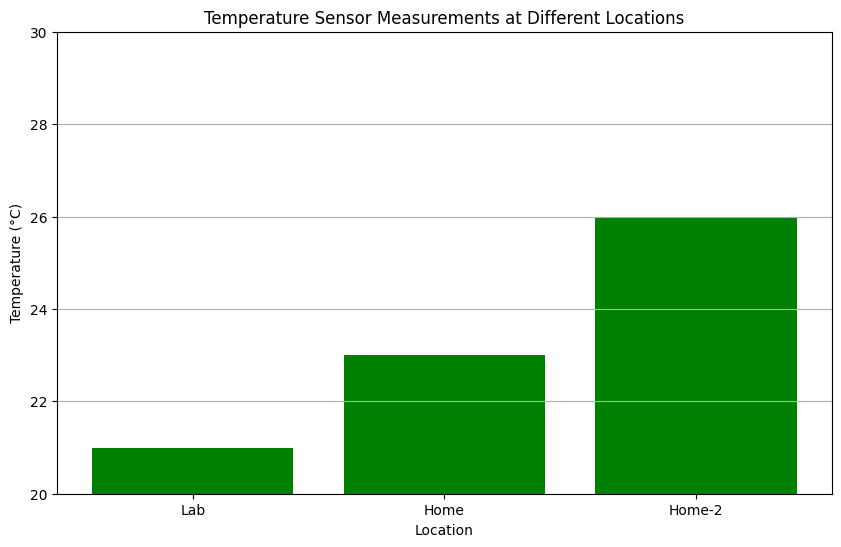

In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Temperature readings at three locations
data = {
    'Location': ['Lab', 'Home', 'Home-2'],
    'Temperature (°C)': [21, 23, 26]
}

#  DataFrame
df = pd.DataFrame(data)

#  DataFrame to show the measurements
print("Temperature Sensor Measurements:")
print(df)

# Plotting the temperature measurements
plt.figure(figsize=(10, 6))
plt.bar(df['Location'], df['Temperature (°C)'], color='green')
plt.title('Temperature Sensor Measurements at Different Locations')
plt.xlabel('Location')
plt.ylabel('Temperature (°C)')
plt.ylim(20, 30)  
plt.grid(axis='y')
plt.show()

## ECG Heart Rate Measurement
Demonstrate that your average heart rate measurement is accurate, as recorded through `LOG_INF()` output, the oscilloscope measurements, and the nRF Connect app, relative to what was set on the function generator.  This should be done for 40, 60, 120, 150, and 180 bpm.  The 25% duty cycle should also be verified. Quantitative analysis should include:
  * Linear regression analysis of the recorded heart rate versus the set heart rate for both the `LOG_INF()` output, oscilloscope measurements, and the nRF Connect app.
  * 95% confidence intervals for the slope and intercept of the linear regression.
  * Verification that the duty cycle of out output is 25% for all heart rates.